# DashLab Demo

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/asaboor-gh/dashlab/HEAD?urlpath=%2Fdoc%2Ftree%2Fdemo.ipynb)

This notebook demonstrates how to use the interactive functionality of `dashlab` to create interactive dashboards.

We'll show two examples:
1. Using `interactive` to interact with multiple functions.
2. Using `DashboardBase` to create a custom interactive widget.
3. Interacting with Plotly's `FigureWidget` selections in a `Dashboard` class.

**Note:** For better content representation, use [ipyslides](https://github.com/asaboor-gh/ipyslides)'s rich content representation features.

Below two images show the outputs generated by cells after this:

**A simple example**
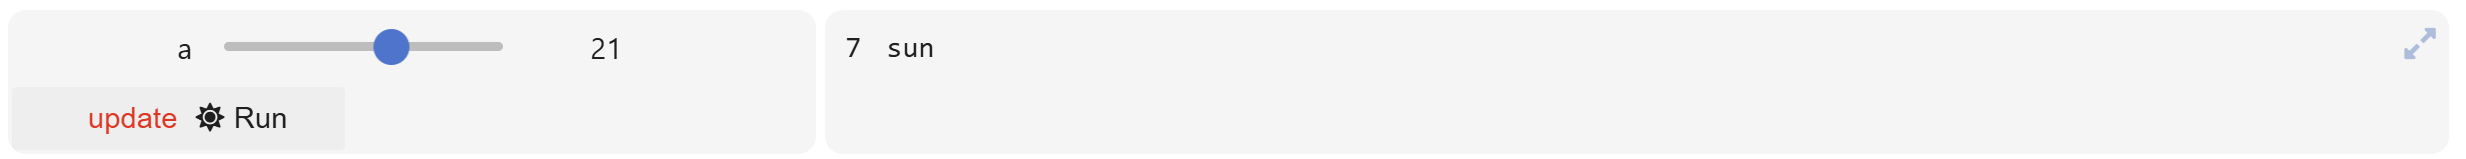
**A comprehensive example**
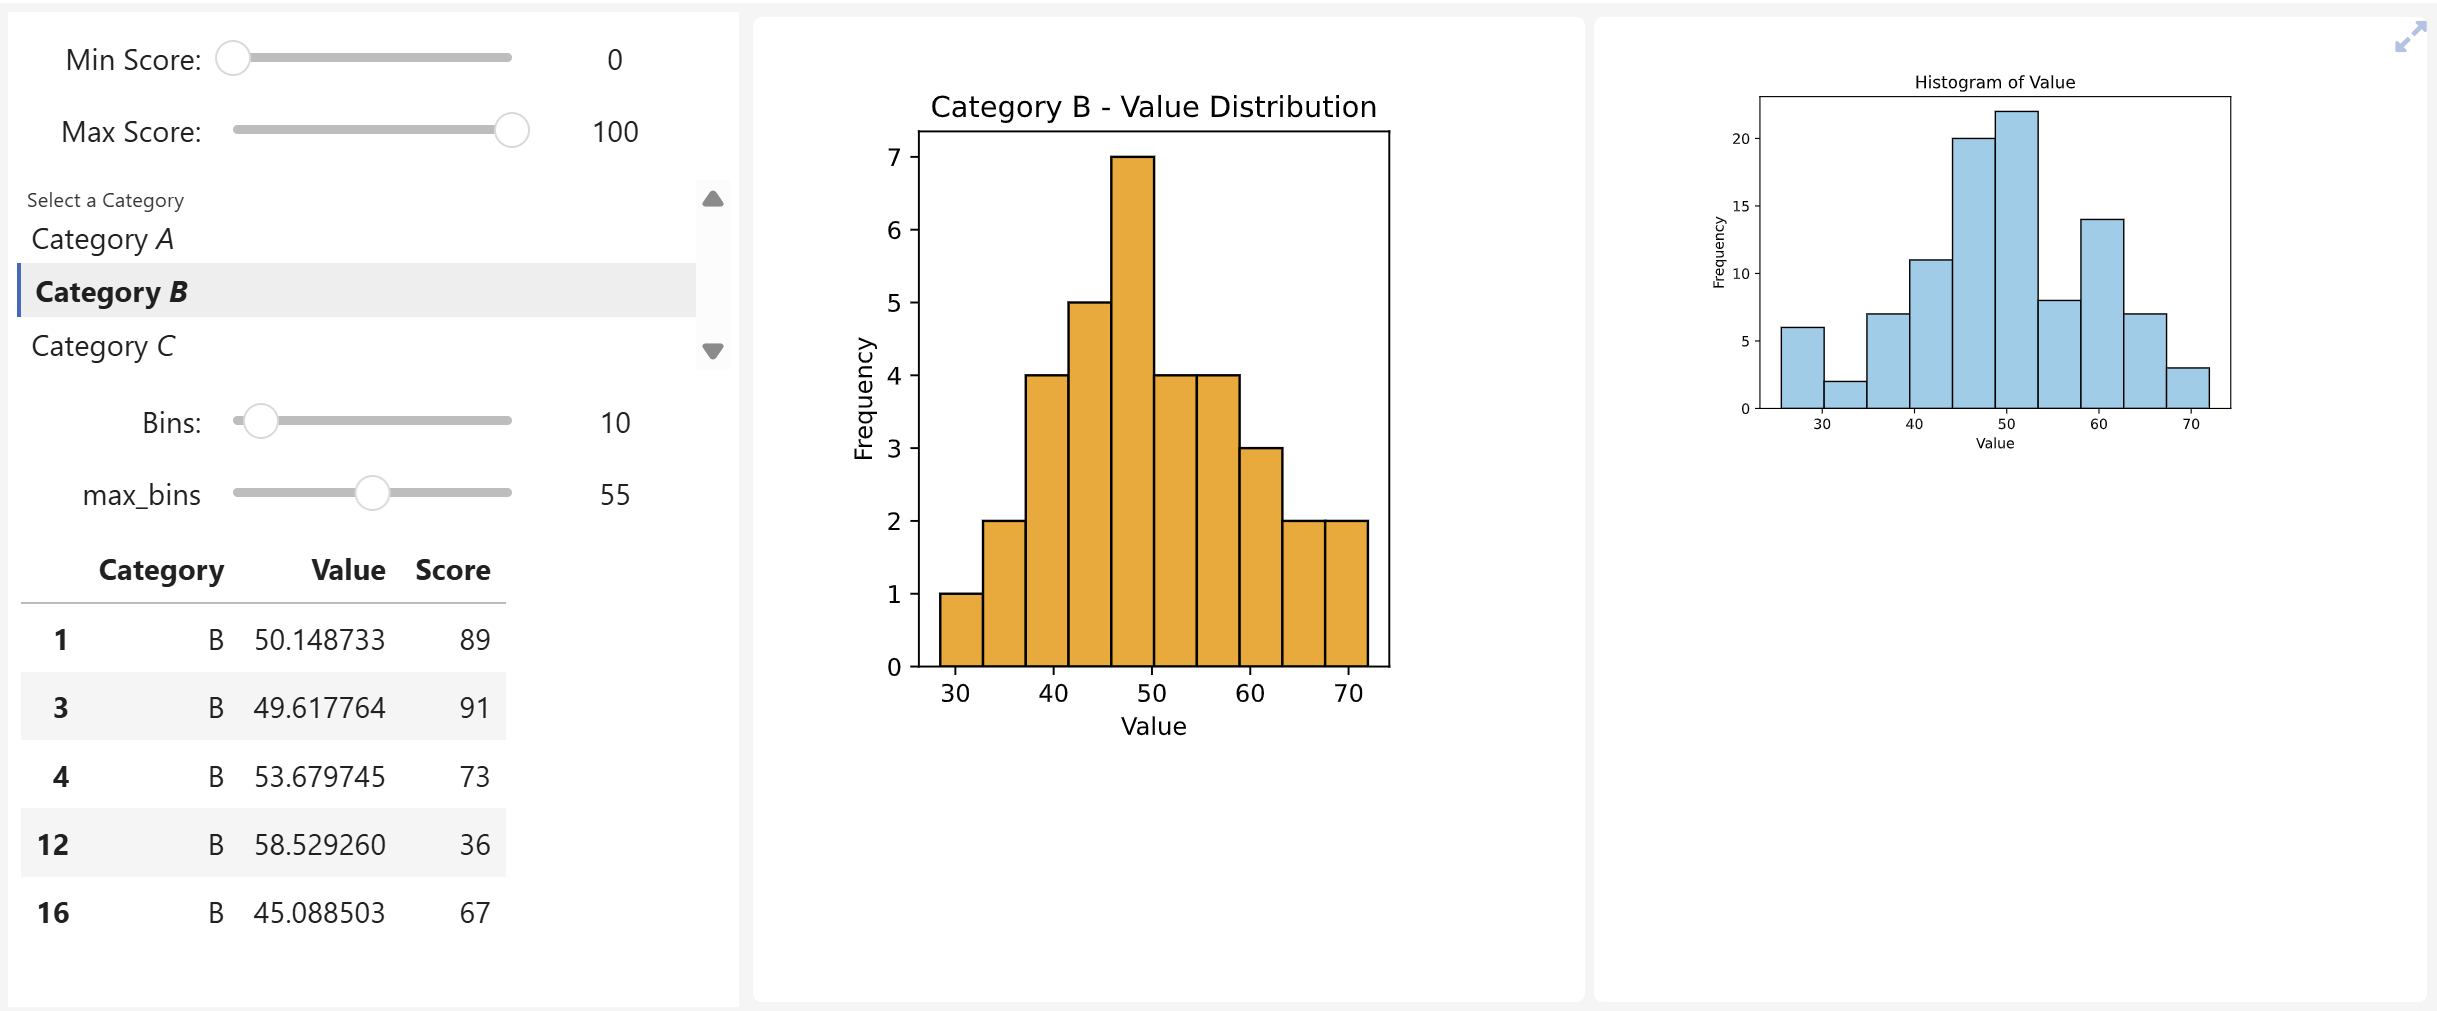

**Plotly Selection example**
![dashboard.gif](dashboard.gif)


In [ ]:
%pip install -q dashlab plotly altair # For jupyterlite

In [ ]:
import ipywidgets as ipw
import dashlab as dl
from time import sleep

@dl.callback('out-print') # create separate output
def myprint(a, b): # b is a btn, so it will run on click
    print('On Click: a: ', a) 
    sleep(1)

dl.interactive(myprint, # multiple functions accepted
    lambda a: print('On Change: a:', a), # this captured by out-main class, this will run on slider change, not held by button
    a = 15, # a slider
    b = dl.button('Run', icon = 'moon', alert='update'), # not just value widgets
    c = 'b.icon', # observe icon of button
    post_init = lambda dash: (
        dash.set_css({'> *': {'background': 'whitesmoke','border-radius': '8px'}}),
        dash.set_layout(
            left_sidebar=['a','b'], 
            center=[(ipw.VBox(), ('out-print','out-main'))], 
            pane_widths=[2,3,0],
        ),
    ),
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as ipw
import dashlab as dl

categories = ['A', 'B', 'C'] 
# Sample DataFrame
np.random.seed(0)
data = pd.DataFrame({
    'Category': np.random.choice(['A', 'B', 'C'], size=100),
    'Value': np.random.randn(100) * 10 + 50,
    'Score': np.random.randint(0, 100, size=100)
})

# Interactive Plotting
@dl.callback('out-bar2', timeit=True)
def plot_histogram(bins, category):
    column='Value'
    plt.figure(figsize=(6,4))
    plt.hist(data[column], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Dynamic Data Filtering
def filter_data(bmax, category, min_score=0, max_score=100):
    filtered = data[
        (data['Category'] == category) &
        (data['Score'] >= min_score) &
        (data['Score'] <= max_score)
    ]
    display(filtered.head())

# Custom Widget Layouts
@dl.callback('out-bar1',timeit=True, debounce=2000)
def custom_ui(category, bins,max_score, min_score):
    subset = data[data['Category'] == category]
    plt.figure(figsize=(3.5,4))
    plt.hist(subset['Value'], bins=bins, color='orange', edgecolor='black')
    plt.title(f'Category {category} - Value Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def set_bins_max(wbins,max_bins):
    wbins.max = max_bins # changing other widget traits

it = dl.interactive(
    filter_data, # captured on out-main
    custom_ui,
    plot_histogram, 
    set_bins_max,
    category= dl.ListWidget(transform=lambda c: f'Category <em>{c}</em>', options=categories, description='Select a Category'),
    min_score=ipw.IntSlider(min=0, max=100, value=0, description='Min Score:'),
    max_score=ipw.IntSlider(min=0, max=100, value=100, description='Max Score:'),
    wbins = ipw.fixed(ipw.IntSlider(min=5, max=30, value=10, description='Bins:')), # passed as widget
    bins = 'wbins.value', # observe value
    max_bins = (10,100),
    bmax = 'wbins.max', # observe max value
)
it.set_layout(
    left_sidebar = ['min_score', 'max_score', 'category', 'wbins','max_bins', 'out-main'], 
    center = ['out-bar1','out-bar2'],
    pane_widths = ['25em','1fr','0'], 
    height = '450px'
)
it

Let's make above dashboard a little better with CSS.

In [ ]:
it.set_css({
    'grid-gap': '4px',
    'padding': '4px',
    'background': 'whitesmoke',
    '.left-sidebar': {'background': 'white','padding':'4px'},
    '.center': {'grid-template-columns': '1fr 1fr',},
    '.center > *': {
        'background': 'white',
        'border-radius': '4px',
        'grid-gap': '8px',
    }
})

# Same app as above through `DashboardBase` class

In [ ]:
import dashlab as dl
class MyInteract(dl.DashboardBase):
    def __init__(self):
        super().__init__() # first initialize base class
        self.set_css({
            'grid-gap': '4px',
            'padding': '4px',
            'background': 'whitesmoke',
            '.left-sidebar': {'background': 'white','padding':'4px'},
            '.center': {'grid-template-columns': '1fr 1fr',},
            '.center > *': {
                'background': 'white',
                'border-radius': '4px',
                'grid-gap': '8px',
            }
        })
        self.set_layout(
            left_sidebar = ['min_score', 'max_score', 'category', 'wbins','max_bins', 'out-main'], 
            center = ['out-bar1','out-bar2'],
            pane_widths =['25em','1fr','0'], 
            height =  '450px',
        )
        
    def _interactive_params(self):
        return dict(
            category= dl.ListWidget(transform=lambda c: f'Category <em>{c}</em>', options=categories, description='Select a Category'),
            min_score=ipw.IntSlider(min=0, max=100, value=0, description='Min Score:'),
            max_score=ipw.IntSlider(min=0, max=100, value=100, description='Max Score:'),
            wbins = ipw.fixed(ipw.IntSlider(min=5, max=30, value=10, description='Bins:')), # passed as widget
            bins = 'wbins.value',
            max_bins = (10,100),
            bmax = 'wbins.max', # observe max value
        )

    @dl.callback
    def filter_data(self, bmax, category, min_score=0, max_score=100):
        filtered = data[
            (data['Category'] == category) &
            (data['Score'] >= min_score) &
            (data['Score'] <= max_score)
        ]
        display(filtered.head())
    
    @dl.callback('out-bar1',timeit=True)
    def custom_ui(self, category, bins,max_score, min_score):
        subset = data[data['Category'] == category]
        plt.figure(figsize=(3.5,4))
        plt.hist(subset['Value'], bins=bins, color='orange', edgecolor='black')
        plt.title(f'Category {category} - Value Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

    @dl.callback('out-bar2',timeit=True, throttle=200) # limit callback rate
    def plot_histogram(self, bins, category):
        column='Value'
        plt.figure(figsize=(6,4))
        plt.hist(data[column], bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    @dl.callback
    def set_bins_max(self, wbins,max_bins):
        wbins.max = max_bins # changing other widget traits

    
MyInteract()

### Plotly's FigureWidget selections using read-to-use `Dashboard` class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

import dashlab as dl

dash = dl.Dashboard(
    fig = dl.patched_plotly(go.FigureWidget()), 
    A = (1,10), omega = (0,20,3), phi = (0,10),
    sdata = 'fig.selected', cdata = 'fig.clicked', fs = '.isfullscreen',
)

@dash.callback
def plot(fig:go.FigureWidget, A, omega,phi): # adding type hint allows auto-completion inside function
    print(A, omega, phi)
    fig.data = []
    x = np.linspace(0,10,100)
    fig.add_trace(go.Scatter(x=x, y=A*np.sin(omega*x + phi), mode='lines+markers'))


@dash.callback('out-click')
def on_click(cdata):
    display(pd.DataFrame(cdata or {}))

@dash.callback
def on_select(sdata):
    plt.scatter(sdata.get('xs',[]),sdata.get('ys',[]))
    plt.title('This plot receives selected data')
    plt.show()
    
@dash.callback
def detect_fs(fig, fs):
    print("isfullscreen = ",fs)
    fig.layout.autosize = False # double trigger
    fig.layout.autosize = True


dash.set_layout(
    left_sidebar = [
        dl.markdown("# Plotly's click/selet demo\nChange controls, `click` and `slection` on fig to right to see effect"),
        'A','omega','phi','out-main',
    ], 
    center = ['fig', dl.markdown("`clicked` data **appears** below!"), 'out-click'],
    pane_widths = [3,7,0],
)
dash.set_css({
    '.left-sidebar':{'background':'whitesmoke'},
    ':fullscreen': {'height': '100vh'},
})

dash